In [79]:
import os
import json
import csv
import pandas as pd
import nltk
from collections import Counter
from nltk import ngrams
from tqdm import tqdm_notebook as tqdm
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
import numpy as np
import xml.etree.ElementTree as ET
from sklearn.cluster import KMeans
from nltk.corpus import stopwords
from wordcloud import WordCloud
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

## Load Data


In [2]:
'''
Get the structured attributes and store them in a dictionary keyed by their EventId
'''

tree = ET.parse('data/AviationData.xml')
root = tree.getroot()
rows = root.getchildren()[0].getchildren()
events_dict = dict()
for row in rows:
    event_id = row.attrib.pop('EventId')
    events_dict[event_id] = dict()
    for attr in row.attrib:
        events_dict[event_id][attr] = row.attrib[attr]

In [3]:
'''
Extract all the narratives and probable causes for events and 
append them to the respective list of attributes in the dictionary
'''


for file in os.listdir('data'):
    if(not file.startswith('Aviation')):
        with open(os.path.join('data',file)) as f:
            json_data = json.load(f)
            for event in json_data['data']:
                events_dict[event['EventId']]['narrative'] = event['narrative']
                events_dict[event['EventId']]['probable_cause'] = event['probable_cause']

In [5]:
'''
Converting the dictionary into a pandas dataframe
'''


events = pd.DataFrame.from_dict(events_dict, orient='index')

In [125]:
events.head(5)

,InvestigationType,AccidentNumber,EventDate,Location,Country,Latitude,Longitude,AirportCode,AirportName,InjurySeverity,...,TotalFatalInjuries,TotalSeriousInjuries,TotalMinorInjuries,TotalUninjured,WeatherCondition,BroadPhaseOfFlight,ReportStatus,PublicationDate,narrative,probable_cause
20001204X00000,Accident,ANC99FA021,01/10/1999,"QUINHAGAK, AK",United States,,,AQH,QUINHAGAK,Non-Fatal,...,0,0,1,0,VMC,APPROACH,Probable Cause,03/31/2000,NTSB investigators either traveled in support ...,Loss of engine power due to fracture of the en...
20001204X00001,Incident,ANC99IA025,01/19/1999,"FAIRBANKS, AK",United States,,,FAI,FAIRBANKS INT'L AIRPORT,Incident,...,0,0,0,4,VMC,LANDING,Probable Cause,06/21/2000,NTSB investigators used data provided by vario...,The improper overhaul of the thrust reverser p...
20001204X00002,Accident,ANC99LA020,01/05/1999,"ANCHORAGE, AK",United States,,,PANC,ANCHORAGE INTERNATIONAL,Non-Fatal,...,0,0,0,6,VMC,TAXI,Probable Cause,04/25/2001,NTSB investigators may not have traveled in su...,The failure of the driver of a vehicle to main...
20001204X00003,Accident,ANC99LA022,01/10/1999,"BETHEL, AK",United States,,,BET,BETHEL,Non-Fatal,...,0,0,0,1,IMC,CLIMB,Probable Cause,04/25/2001,NTSB investigators may not have traveled in su...,The pilot's attempted flight into adverse weat...
20001204X00004,Accident,ANC99LA023,01/12/1999,"CHEVAK, AK",United States,,,VAK,CHEVAK,Non-Fatal,...,0,0,0,1,VMC,DESCENT,Probable Cause,04/20/2000,NTSB investigators may not have traveled in su...,The pilot's continued flight into adverse weat...


In [17]:
'''
Getting to know the dataframe
'''

print(list(events))
events.describe()

['InvestigationType', 'AccidentNumber', 'EventDate', 'Location', 'Country', 'Latitude', 'Longitude', 'AirportCode', 'AirportName', 'InjurySeverity', 'AircraftDamage', 'AircraftCategory', 'RegistrationNumber', 'Make', 'Model', 'AmateurBuilt', 'NumberOfEngines', 'EngineType', 'FARDescription', 'Schedule', 'PurposeOfFlight', 'AirCarrier', 'TotalFatalInjuries', 'TotalSeriousInjuries', 'TotalMinorInjuries', 'TotalUninjured', 'WeatherCondition', 'BroadPhaseOfFlight', 'ReportStatus', 'PublicationDate', 'narrative', 'probable_cause']


,InvestigationType,AccidentNumber,EventDate,Location,Country,Latitude,Longitude,AirportCode,AirportName,InjurySeverity,...,TotalFatalInjuries,TotalSeriousInjuries,TotalMinorInjuries,TotalUninjured,WeatherCondition,BroadPhaseOfFlight,ReportStatus,PublicationDate,narrative,probable_cause
count,76133,76133,76133,76133,76133,76133,76133,76133,76133,76133,...,76133,76133,76133,76133,76133,76133,76133,76133,76133,76133
unique,2,76133,12180,24702,174,16343,17471,9489,22284,120,...,118,41,63,364,4,13,4,3403,75557,47435
top,Accident,NYC01LA208,06/30/1984,"ANCHORAGE, AK",United States,,,,,Non-Fatal,...,0,0,0,1,VMC,LANDING,Probable Cause,,,
freq,73241,1,25,361,72017,52676,52685,33429,29617,57871,...,39855,42313,39733,21948,67719,18442,71227,13013,228,26344


# Narrative Exploration

In [6]:
'''
Dataframe with all non-empty narratives
'''


events_with_narrative = events.loc[events['narrative'] != '']

In [18]:
len(events_with_narrative['narrative'])

75905

In [24]:
'''
nosw_tokens_narrative: Store counts of all tokens (except for stopwords, tokens with length 1 and 
tokens from sentences containing NTSB) from narratives

yearwise_tokens_narrative: Store yearwise count of all tokens as above
''' 


swords = stopwords.words('english')
nosw_tokens_narrative = Counter()
yearwise_tokens_narrative = dict()
index = 0
for narrative in tqdm(events_with_narrative['narrative']):
    date = events_with_narrative.iloc[index]['EventDate']
    if(date != ''):
        year = date.split('/')[2]
        if(year not in yearwise_tokens_narrative.keys()):
            yearwise_tokens_narrative[year] = Counter()
        for sent in sent_tokenize(narrative):
            if('NTSB' not in sent):
                for word in word_tokenize(sent):
                    if(len(word) != 1 and word.lower() not in swords):
                        nosw_tokens_narrative[word.lower()] += 1
                        yearwise_tokens_narrative[year][word.lower()] += 1
    else:
        for sent in sent_tokenize(narrative):
            if('NTSB' not in sent):
                for word in word_tokenize(sent):
                    if(len(word) != 1 and word.lower() not in swords):
                        nosw_tokens_narrative[word.lower()] += 1
    index += 1

In [25]:
'''
Stores the 20 most frequent tokens for each year in a csv, for studying the trends, if any.
'''


with open('yearwise_narrative_tokens.csv', 'w') as f:
    csvwriter = csv.writer(f)
    for year in yearwise_tokens_narrative:
        tokens = [year]
        for token in yearwise_tokens_narrative[year].most_common(20):
            if(token != "\'s"):
                tokens.append(token)
        csvwriter.writerow(tokens)

In [26]:
'''
20 most frequent tokens from all the years
'''


nosw_tokens_narrative.most_common(20)

[('airplane', 108345),
 ('pilot', 102931),
 ('engine', 53246),
 ('landing', 51891),
 ('flight', 43641),
 ('fuel', 42928),
 ('runway', 42740),
 ('left', 41651),
 ('right', 35357),
 ('accident', 33467),
 ('reported', 32135),
 ('aircraft', 31613),
 ('power', 29514),
 ('gear', 26440),
 ('feet', 25890),
 ('acft', 25885),
 ('revealed', 25285),
 ('ground', 24892),
 ('stated', 23348),
 ("'s", 22240)]

# Probable Cause Exploration

In [27]:
'''
Dataframe with non-empty cause
'''

events_with_cause = events.loc[events['probable_cause'] != '']
len(events_with_cause)

49789

In [28]:
'''
nosw_tokens_cause: Store counts of all tokens (except for stopwords and tokens with length 1) from probable causes

yearwise_tokens_cause: Store yearwise count of all tokens as above

'''


nosw_tokens_cause = Counter()
yearwise_tokens_cause = dict()
index = 0
for narrative in tqdm(events_with_cause['probable_cause']):
    if(date != ''):
        year = events_with_cause.iloc[index]['EventDate'].split('/')[2]
        if(year not in yearwise_tokens_cause.keys()):
            yearwise_tokens_cause[year] = Counter()
        for sent in sent_tokenize(narrative):
            for word in word_tokenize(sent):
                if(len(word) != 1 and word.lower() not in swords):
                    nosw_tokens_cause[word.lower()] += 1
                    yearwise_tokens_cause[year][word.lower()] += 1
    else:
        for sent in sent_tokenize(narrative):
            for word in word_tokenize(sent):
                if(len(word) != 1 and word.lower() not in swords):
                    nosw_tokens_cause[word.lower()] += 1
    index += 1

In [29]:
'''
Stores the 20 most frequent tokens for each year in a csv, for studying the trends, if any.
'''

with open('yearwise_probable_cause_tokens.csv', 'w') as f:
    csvwriter = csv.writer(f)
    for year in yearwise_tokens_cause:
        tokens = [year]
        for token in yearwise_tokens_cause[year].most_common(20):
            if(token != "\'s"):
                tokens.append(token)
        csvwriter.writerow(tokens)

In [30]:
'''
20 most frequent tokens from all the years
'''


nosw_tokens_cause.most_common(20)

[('pilot', 41524),
 ("'s", 36838),
 ('failure', 28385),
 ('landing', 19628),
 ('maintain', 15270),
 ('control', 13285),
 ('loss', 13029),
 ('resulted', 12505),
 ('accident', 11941),
 ('engine', 11655),
 ('factor', 10350),
 ('power', 9997),
 ('fuel', 9623),
 ('factors', 9190),
 ('inadequate', 8991),
 ('flight', 8606),
 ('contributing', 8565),
 ('terrain', 8379),
 ('airplane', 8267),
 ('improper', 8016)]

## KMeans with Probable Cause Data

In [31]:
'''
Custom tokenizer for getting tokens from the description of a cause. Returns all words but stop words 
and words/tokens with length 1. 
'''


def cause_tokenizer(doc):
    tokens = []
    for sent in sent_tokenize(doc):
        if('NTSB' not in sent):
            for word in word_tokenize(sent):
                if(word.lower() not in swords and len(word.strip()) != 1):
                    tokens.append(word.lower())
    return tokens

In [34]:
'''
Get the tf-idf vectors for the probable cause, treating each probable cause as a document. 
'''

docs_cause = list(events.loc[events['probable_cause'] != '']['probable_cause'])
tf_idf_vectorizer_cause = TfidfVectorizer(tokenizer=cause_tokenizer)
doc_vectors_cause = tf_idf_vectorizer_cause.fit_transform(docs_cause)

In [35]:
'''
Run K-Means on the tf-idf vectors for 
'''


cluster_model_cause = KMeans(n_clusters=8, max_iter=100000)
kmeans_cause = cluster_model_cause.fit_transform(doc_vectors_cause)

In [75]:
'''
Get the most important/indicative words for each cluster
'''


tf_feature_names = tf_idf_vectorizer_cause.get_feature_names()
order_centroids = cluster_model_cause.cluster_centers_.argsort()[:, ::-1]
for i in range(8):
    message = "Cluster %d:" % i
    for ind in order_centroids[i, :10]:
        message += " " + tf_feature_names[ind] + ","
    print(message[:-1])
    print

Cluster 0: directional, control, maintain, failure, pilot, 's, landing, roll, airplane, takeoff
Cluster 1: undetermined, reasons, loss, power, engine, reason, forced, terrain, landing, suitable
Cluster 2: pilot, 's, landing, failure, accident, resulted, engine, factor, loss, airplane
Cluster 3: maintain, failure, airspeed, pilot, 's, clearance, adequate, stall, altitude, inadvertent
Cluster 4: wind, compensation, conditions, crosswind, inadequate, pilot, 's, gusty, control, factor
Cluster 5: conditions, weather, carburetor, flight, instrument, pilot, meteorological, icing, 's, adverse
Cluster 6: fuel, exhaustion, engine, power, due, loss, starvation, pilot, inadequate, 's
Cluster 7: flare, landing, improper, bounced, recovery, hard, pilot, 's, student, resulted


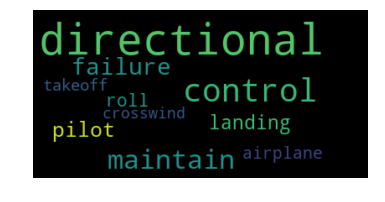

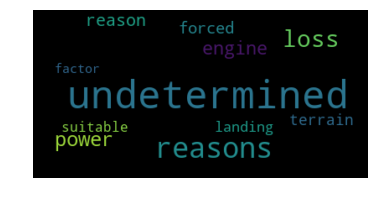

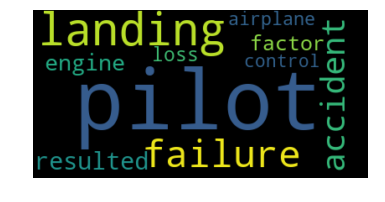

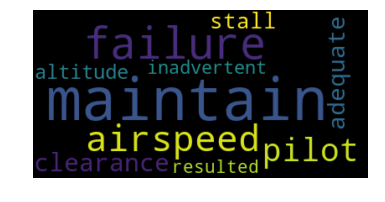

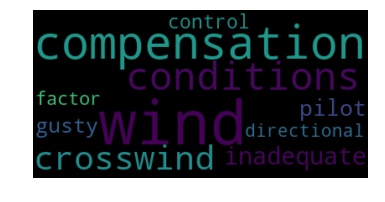

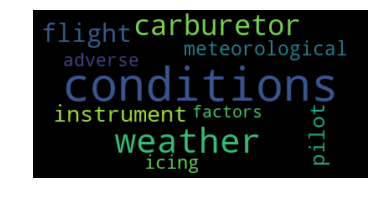

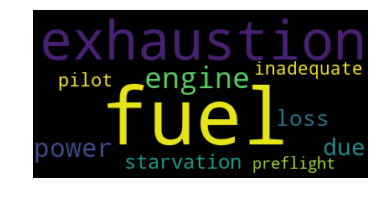

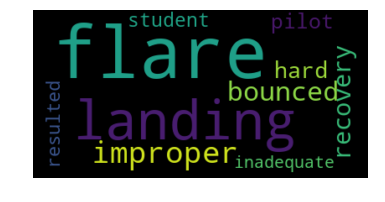

In [81]:
'''
Generating word clouds
'''

for i in range(8):
    cnt = Counter()
    count = 1
    for word in np.array(tf_feature_names)[order_centroids[i,:11]]:
        if(word != '\'s'):
            cnt[word] = 1/count
            count += 1
    wc = WordCloud()
    wc.generate_from_frequencies(frequencies=cnt)
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.savefig('word_clouds/cluster_' + str(i) + '.png')
    plt.show()
    

In [89]:
for cluster in range(8):
    print(len(clustered_causes[cluster]))

4258
3142
24952
5712
2242
3085
4494
1904


In [101]:
clustered_causes[5]

["The pilot's attempted flight into adverse weather.  Factors associated with the accident were the pilot's inadequate evaluation of the weather conditions, icing conditions, and an inadvertent stall. ",
 "The pilot's continued flight into adverse weather conditions.  Factors associated with the accident were freezing rain, an accumulation of ice on the wings and ailerons, and diminished directional control. ",
 "the pilot's failure to maintain proper altitude/clearance on the approach and his flight into known icing conditions. Factors relating to this accident were the pilot flying with known equipment deficiencies, the pilot's physical impairment (alcohol), the icing conditions, and the trees. ",
 'the spatial disorientation and loss of control by the pilot after a reported vacuum failure.  Factors were instrument flight conditions and icing conditions.',
 "The pilot's continued flight into adverse weather that resulted in structural icing and subsequently an aerodynamic stall on la

In [40]:
'''
Find the cluster assignments for each event based on the probable cause
'''


cluster_assignments_cause = np.argmin(kmeans_cause,1)
clustered_causes = dict()
for i in range(8):
    clustered_causes[i] = []
for ind in range(len(cluster_assignments_cause)):
    clustered_causes[cluster_assignments_cause[ind]].append(docs_cause[ind])

In [41]:
'''
tokens_nosw_cluster_cause: stores the most frequent tokens (without stopwords and single length tokens) 
for each cluster

all_tokens_cluster_cause: stores all the tokens for each cluster in the sequence order. 
Used for generating collocations
'''


all_tokens_cluster_cause = dict()
tokens_nosw_cluster_cause = dict()
for i in range(8):
    all_tokens_cluster_cause[i] = []
    tokens_nosw_cluster_cause[i] = []
    for cluster in clustered_causes[i]:
        for sent in sent_tokenize(cluster):
            for word in word_tokenize(sent):
                if(word.lower() not in swords and len(word) != 1):
                    tokens_nosw_cluster_cause[i].append(word.lower())
                all_tokens_cluster_cause[i].append(word.lower())
    tokens_nosw_cluster_cause[i] = Counter(tokens_nosw_cluster_cause[i])

In [49]:
'''
Store the most frequent collocations for each cluster in a file to study
'''

for n in range(4):
    with open('ngrams/cluster_' + str(n) + 'grams.txt', 'w') as f:
        for i in range(8):
            f.write("CLUSTER " + str(i))
            f.write("\n\n")
            if(n == 0):
                for x in tokens_nosw_cluster_cause[i].most_common(20):
                    f.write(x[0][0])
                    f.write(" ")
                    f.write(str(x[1]))
                    f.write("\n")
                f.write("\n\n\n")
            else:
                for x in Counter(ngrams(all_tokens_cluster_cause[i],n)).most_common(20):
                    f.write(x[0][0])
                    f.write(" ")
                    f.write(str(x[1]))
                    f.write("\n")
                f.write("\n\n\n")

## LDA

In [73]:
'''
For printing the top words for each topic in a learned LDA model
'''

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [82]:
'''
Train an LDA model
'''


lda = LatentDirichletAllocation(n_components=8,
                                learning_method='online',
                                learning_offset=50,
                                random_state=0)
lda.fit(doc_vectors)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=8, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [83]:
print("\nTopics in LDA model:")
print_top_words(lda, tf_feature_names, 11)


Topics in LDA model:
Topic #0: incapacitation starting unit likely crack building thrust attack failures revealed malfunctions
Topic #1: attention diverted propeller turbulence wire transmission encounter blade fatigue hydraulic door
Topic #2: excursion postaccident reveal fire long load ignition airframe steering cross truck
Topic #3: pilot 's clearance conditions flight maintain failure terrain weather night visual
Topic #4: brake parking seizure powerplant agricultural vertical `` '' stick rock set
Topic #5: engine power loss fuel undetermined reasons due forced landing exhaustion terrain
Topic #6: pilot 's landing control failure maintain directional resulted airplane takeoff improper
Topic #7: oil rod tank selector examination connecting bolt leak cap torque bearing



In [85]:
'''
Identify the most important topic for each cause
'''

transformed_docs_lda = lda.transform(doc_vectors)
lda_clusters = dict()
for cluster in range(8):
    lda_clusters[cluster] = []
count = 0
for doc in transformed_docs_lda:
    cluster = np.argmax(doc)
    lda_clusters[cluster].append(docs[count])
    count += 1

In [86]:
for cluster in range(8):
    print(len(lda_clusters[cluster]))

265
1182
236
8544
144
12582
26177
659


In [99]:
lda_clusters[3]

['The failure of the driver of a vehicle to maintain an adequate visual lookout. ',
 "The pilot's attempted flight into adverse weather.  Factors associated with the accident were the pilot's inadequate evaluation of the weather conditions, icing conditions, and an inadvertent stall. ",
 "The pilot's continued flight into adverse weather conditions.  Factors associated with the accident were freezing rain, an accumulation of ice on the wings and ailerons, and diminished directional control. ",
 "The pilot's failure to adhere to the missed approach procedure resulting in a collision with terrain.  Contributing factors were fog and the rotorcraft rated pilot's lack of fixed wing certification/experience. ",
 "Fuel exhaustion due to inadequate planning and the pilot's failure to refuel the airplane. Factors were the weather conditions and hilly terrain. ",
 "the pilot's failure to maintain proper altitude/clearance on the approach and his flight into known icing conditions. Factors relati

## Yearwise Cluster Trends

In [102]:
'''
yearwise: dictionary mapping a year to the list of indices of events that belong to that year
'''

events_with_date = events.loc[events['EventDate'] != '']
yearwise = dict()
index_to_year = dict()
index = 0
for date in events_with_date['EventDate']:
    year = date.split('/')[2]
    if(year not in yearwise.keys()):
        yearwise[year] = [index]
    else:
        yearwise[year].append(index)
    index_to_year[index] = year
    index += 1

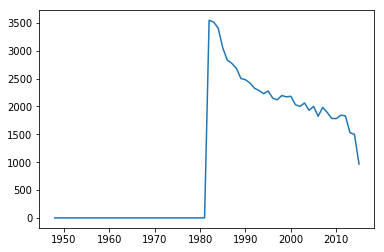

In [103]:
years = []
lens = []
for year in yearwise.keys():
    years.append(int(year))
    lens.append(len(yearwise[year]))
years = np.array(years)
lens = np.array(lens)
plt.plot(np.sort(years), lens[np.argsort(years)])

In [104]:
yearwise_causes_docs = events_with_date['probable_cause']
yearwise_narratives_docs = events_with_date['narrative']

In [107]:
'''
Transform all events with a valid date field
'''



yearwise_causes_vec = tf_idf_vectorizer_cause.transform(yearwise_causes_docs)
yearwise_causes_lda = lda.transform(yearwise_causes_vec)
yearwise_causes_kmeans = cluster_model_cause.transform(yearwise_causes_vec)

In [109]:
'''
yearwise_topics: contains the number of events belonging to a particular year and LDA topic

yearwise_cluster: contains the number of events belonging to a particular year and K-Means cluster
'''

yearwise_topics = dict()
yearwise_clusters = dict()
for i in range(8):
    yearwise_topics[i] = Counter()
    yearwise_clusters[i] = Counter()
for i in range(len(yearwise_causes_docs)):
    if(yearwise_causes_docs[i] != ''):
        topic = np.argmax(yearwise_causes_lda[i])
        cluster = np.argmin(yearwise_causes_kmeans[i])
        yearwise_topics[topic][index_to_year[i]] += 1
        yearwise_clusters[cluster][index_to_year[i]] += 1

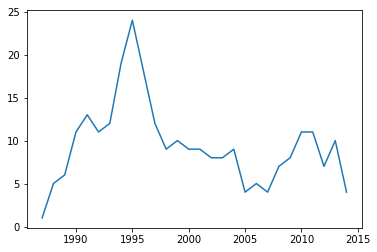

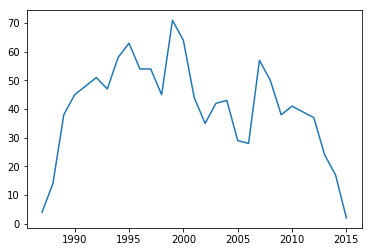

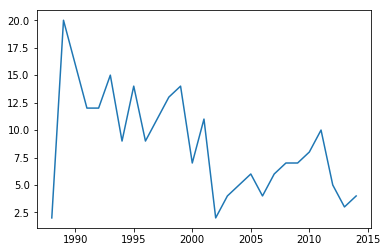

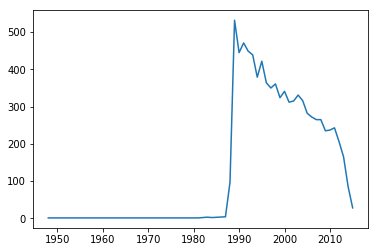

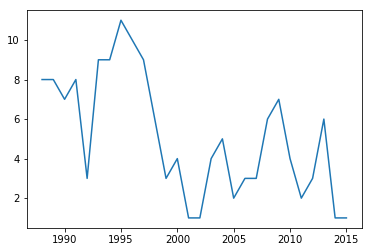

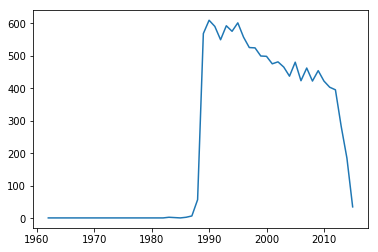

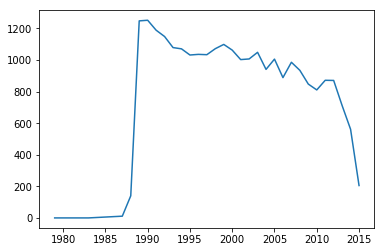

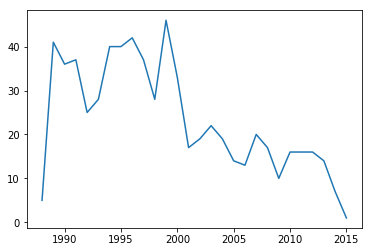

In [110]:
'''
Plot the number of events vs year for each LDA topic
'''


for topic in yearwise_topics:
    years = []
    counts = []
    for year in yearwise_topics[topic]:
        years.append(int(year))
        counts.append(yearwise_topics[topic][year])
    counts = np.array(counts)
    years = np.array(years)
    plt.plot(np.sort(years), counts[np.argsort(years)])
    plt.savefig("topic_" + str(topic) + "_yearwise.png")
    plt.show()

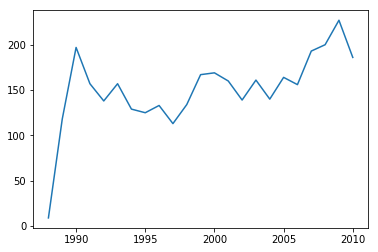

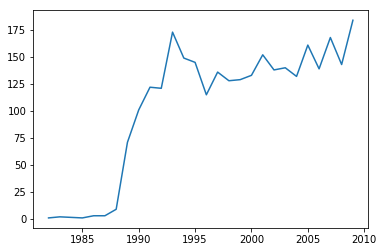

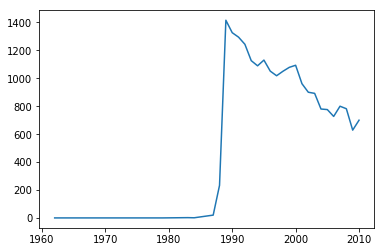

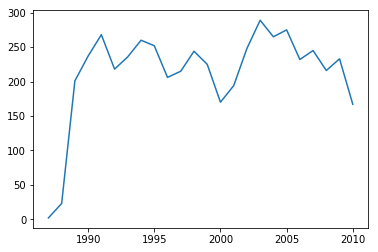

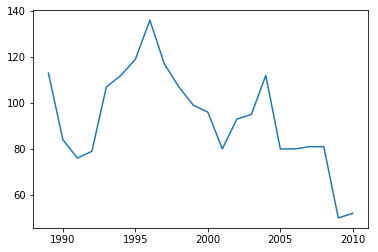

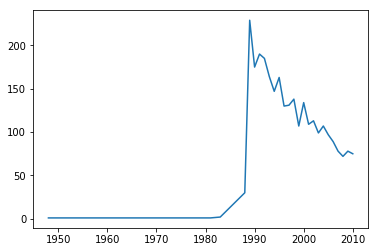

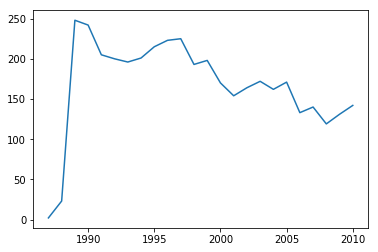

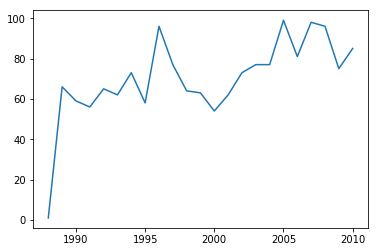

In [119]:
'''
Plot the number of events vs year for each K-Means cluster
'''


for cluster in yearwise_clusters:
    years = []
    counts = []
    for year in yearwise_clusters[cluster]:
        years.append(int(year))
        counts.append(yearwise_clusters[cluster][year])
    counts = np.array(counts)
    years = np.array(years)
    plt.plot(np.sort(years)[:-5], counts[np.argsort(years)][:-5])
    plt.savefig("cluster_" + str(cluster) + "_yearwise.png")
    plt.show()

## Auxiliary/Extra Exploration

In this section, I check for the distribution of some structured attributes according to the K-Means clusters

In [55]:
'''
clustered_events_cause: contains events belonging to each cluster, based on the probable cause
'''


cause_events = events.loc[events['probable_cause'] != '']
clustered_events_cause = dict()
for cluster in range(8):
    clustered_events_cause[cluster] = cause_events.iloc[np.where(cluster_assignments_cause == cluster)[0]]

In [56]:
'''
Distribution for the number of engines
'''

all_cnt = Counter(events['NumberOfEngines'])
for cluster in range(8):
    print("CLUSTER ", cluster)
    cnt = Counter(clustered_events_cause[cluster]['NumberOfEngines'])
    for key in cnt.keys():
        cnt[key] = round(cnt[key],4)
    print(cnt)

CLUSTER  0
Counter({'1': 4020, '2': 177, '': 46, '0': 12, '4': 1, '3': 1, '24': 1})
CLUSTER  1
Counter({'1': 2835, '2': 273, '': 20, '0': 11, '4': 3})
CLUSTER  2
Counter({'1': 19286, '2': 4261, '': 544, '0': 443, '3': 223, '4': 195})
CLUSTER  3
Counter({'1': 5092, '2': 407, '0': 111, '': 100, '3': 2})
CLUSTER  4
Counter({'1': 2088, '2': 73, '': 47, '0': 34})
CLUSTER  5
Counter({'1': 2602, '2': 441, '': 24, '0': 15, '4': 2, '3': 1})
CLUSTER  6
Counter({'1': 4018, '2': 439, '': 21, '4': 8, '0': 6, '3': 1, '18': 1})
CLUSTER  7
Counter({'1': 1755, '2': 118, '': 19, '0': 9, '3': 2, '4': 1})


In [59]:
'''
Distribution for the the air carrier
'''


all_cnt = Counter(events['AirCarrier'])
for cluster in range(8):
    print("CLUSTER ", cluster)
    cnt = Counter(clustered_events_cause[cluster]['AirCarrier'])
    for key in cnt.keys():
        if(key == ''):
            cnt[key] = 0
    print(cnt.most_common(10))

CLUSTER  0
[('HAWKEYE CHARTER SERVICE, INC', 1), ('MIAMI VALLEY AVIATION', 1), ('VALUE JET AIRLINES (DBA: VALUJET)', 1), ('MOUNTAIN AIR CARGO INC.', 1), ('SPIRIT MOUNTAIN AVIATION LC', 1), ('(DBA: ALASKA TROPHY CONNECTION)', 1), ('LENTSCH, WILLIAM J. (DBA: TAMARACK AIR, LTD.)', 1), ('SOUTHCENTRAL AIR, INC.', 1), ('TRAVELAIR TAXI INC.', 1), ('GULF AIR TAXI, INC.', 1)]
CLUSTER  1
[('CORPORATE AIR', 2), ('ATLANTIC COAST AIRLINES (DBA: DELTA CONNECTION)', 2), ('STAR WEST AVIATION', 1), ('MORRISON FLYING SERVICE', 1), ('SOUTH CENTRAL AIR', 1), ('(DBA: LINDSAY AIR)', 1), ('AVMAC AIR, INC.', 1), ('WEST COAST AIR CARGO (DBA: WEST COAST AIR CARGO)', 1), ('BERNADETTE PRINGLE (DBA: DOMTRAV AIRWAYS)', 1), ('POLYNESIAN AIRWARS', 1)]
CLUSTER  2
[('UNITED AIRLINES', 31), ('AMERICAN AIRLINES', 24), ('CONTINENTAL AIRLINES', 20), ('DELTA AIR LINES INC', 17), ('CONTINENTAL AIRLINES, INC.', 16), ('SOUTHWEST AIRLINES CO', 16), ('USAIR', 15), ('SIMMONS AIRLINES (DBA: AMERICAN EAGLE)', 11), ('AMERICAN AIRLIN

In [61]:
'''
Distribution for the airport
'''


all_cnt = Counter(events['AirportName'])
for cluster in range(8):
    print("CLUSTER ", cluster)
    cnt = Counter(clustered_events_cause[cluster]['AirportName'])
    for key in cnt.keys():
        if(key == '' or key == 'n/a'):
            cnt[key] = 0
    print(cnt.most_common(10))

CLUSTER  0
[('N/A', 32), ('Private Airstrip', 19), ('Private', 17), ('PRIVATE', 12), ('MERRILL FIELD', 10), ('CENTENNIAL', 9), ('NONE', 8), ('Merrill Field', 8), ('MERRILL', 7), ('Falcon Field Airport', 7)]
CLUSTER  1
[('Private', 14), ('Private Airstrip', 13), ('None', 9), ('NONE', 8), ('PRIVATE AIRSTRIP', 6), ('PRIVATE', 6), ('N/A', 6), ('CENTENNIAL', 3), ('NORTHWEST REGIONAL', 3), ('CHINO', 3)]
CLUSTER  2
[('N/A', 469), ('PRIVATE', 89), ('Private', 76), ('Private Airstrip', 62), ('NONE', 45), ('PRIVATE AIRSTRIP', 40), ('None', 36), ('MIAMI INTERNATIONAL', 27), ('CENTENNIAL', 26), ('MERRILL FIELD', 24)]
CLUSTER  3
[('N/A', 115), ('Private', 35), ('PRIVATE', 21), ('None', 16), ('NONE', 15), ('Private Airstrip', 13), ('PRIVATE AIRSTRIP', 8), ('Private Strip', 8), ('NA', 7), ('PRIVATE STRIP', 6)]
CLUSTER  4
[('N/A', 18), ('PRIVATE', 16), ('SEDONA', 9), ('MERRILL FIELD', 5), ('SOLDOTNA', 5), ('PRIVATE AIRSTRIP', 5), ('Private', 5), ('ERNEST A. LOVE FIELD', 4), ('PALWAUKEE', 4), ('FRONT R

In [63]:
'''
Distribution for the type of investigation
'''




all_cnt = Counter(events['InvestigationType'])
for cluster in range(8):
    print("CLUSTER ", cluster)
    cnt = Counter(clustered_events_cause[cluster]['InvestigationType'])
    for key in cnt.keys():
        cnt[key] = round(cnt[key],4)
    print(cnt)

CLUSTER  0
Counter({'Accident': 4242, 'Incident': 16})
CLUSTER  1
Counter({'Accident': 3114, 'Incident': 28})
CLUSTER  2
Counter({'Accident': 23683, 'Incident': 1269})
CLUSTER  3
Counter({'Accident': 5696, 'Incident': 16})
CLUSTER  4
Counter({'Accident': 2235, 'Incident': 7})
CLUSTER  5
Counter({'Accident': 3071, 'Incident': 14})
CLUSTER  6
Counter({'Accident': 4458, 'Incident': 36})
CLUSTER  7
Counter({'Accident': 1900, 'Incident': 4})


In [64]:
'''
Distribution for the make of the aircraft
'''


all_cnt = Counter(events['Make'])
for cluster in range(8):
    print("CLUSTER ", cluster)
    cnt = Counter(clustered_events_cause[cluster]['Make'])
    for key in cnt.keys():
        cnt[key] = round(cnt[key],4)
    print(cnt.most_common(5))

CLUSTER  0
[('CESSNA', 868), ('Cessna', 753), ('PIPER', 435), ('Piper', 368), ('Beech', 61)]
CLUSTER  1
[('Cessna', 419), ('CESSNA', 364), ('Piper', 276), ('PIPER', 252), ('Beech', 128)]
CLUSTER  2
[('CESSNA', 3630), ('Cessna', 3006), ('PIPER', 2178), ('Piper', 1693), ('BEECH', 810)]
CLUSTER  3
[('CESSNA', 756), ('Cessna', 733), ('PIPER', 439), ('Piper', 428), ('Beech', 185)]
CLUSTER  4
[('Cessna', 503), ('CESSNA', 399), ('Piper', 218), ('PIPER', 202), ('Maule', 35)]
CLUSTER  5
[('CESSNA', 668), ('Cessna', 484), ('PIPER', 417), ('Piper', 311), ('BEECH', 147)]
CLUSTER  6
[('CESSNA', 817), ('Cessna', 740), ('PIPER', 464), ('Piper', 431), ('BEECH', 203)]
CLUSTER  7
[('Cessna', 565), ('CESSNA', 489), ('PIPER', 119), ('Piper', 110), ('BEECH', 47)]


In [69]:
'''
Distribution for the weather conditions
'''


all_cnt = Counter(events['WeatherCondition'])
for cluster in range(8):
    print("CLUSTER ", cluster)
    cnt = Counter(clustered_events_cause[cluster]['WeatherCondition'])
    for key in cnt.keys():
        if(key == '' or key == 'UNK'):
            cnt[key] = 0
    print(cnt.most_common(5))

CLUSTER  0
[('VMC', 4199), ('IMC', 52), ('UNK', 0), ('', 0)]
CLUSTER  1
[('VMC', 3018), ('IMC', 75), ('UNK', 0), ('', 0)]
CLUSTER  2
[('VMC', 23522), ('IMC', 1230), ('UNK', 0), ('', 0)]
CLUSTER  3
[('VMC', 5469), ('IMC', 209), ('UNK', 0), ('', 0)]
CLUSTER  4
[('VMC', 2224), ('IMC', 12), ('UNK', 0), ('', 0)]
CLUSTER  5
[('IMC', 1706), ('VMC', 1296), ('UNK', 0), ('', 0)]
CLUSTER  6
[('VMC', 4363), ('IMC', 119), ('UNK', 0), ('', 0)]
CLUSTER  7
[('VMC', 1889), ('IMC', 14), ('', 0)]


In [66]:
'''
Distribution for the broad phase of flight
'''


all_cnt = Counter(events['BroadPhaseOfFlight'])
for cluster in range(8):
    print("CLUSTER ", cluster)
    cnt = Counter(clustered_events_cause[cluster]['BroadPhaseOfFlight'])
    for key in cnt.keys():
        if(key == ''):
            cnt[key] = 0
    print(cnt.most_common(5))

CLUSTER  0
[('LANDING', 2793), ('TAKEOFF', 964), ('MANEUVERING', 89), ('GO-AROUND', 88), ('TAXI', 74)]
CLUSTER  1
[('TAKEOFF', 958), ('CRUISE', 645), ('MANEUVERING', 441), ('APPROACH', 329), ('CLIMB', 170)]
CLUSTER  2
[('LANDING', 6343), ('TAKEOFF', 5338), ('CRUISE', 3145), ('MANEUVERING', 2984), ('APPROACH', 2307)]
CLUSTER  3
[('MANEUVERING', 2069), ('TAKEOFF', 1180), ('APPROACH', 827), ('LANDING', 490), ('CRUISE', 266)]
CLUSTER  4
[('LANDING', 1290), ('TAKEOFF', 411), ('APPROACH', 164), ('TAXI', 117), ('MANEUVERING', 72)]
CLUSTER  5
[('CRUISE', 1191), ('MANEUVERING', 461), ('APPROACH', 436), ('TAKEOFF', 320), ('CLIMB', 177)]
CLUSTER  6
[('CRUISE', 1499), ('APPROACH', 874), ('TAKEOFF', 855), ('MANEUVERING', 355), ('DESCENT', 342)]
CLUSTER  7
[('LANDING', 1769), ('GO-AROUND', 20), ('TAKEOFF', 18), ('CRUISE', 15), ('APPROACH', 12)]


In [68]:
'''
Distribution for the airport code
'''


all_cnt = Counter(events['AirportCode'])
for cluster in range(8):
    print("CLUSTER ", cluster)
    cnt = Counter(clustered_events_cause[cluster]['AirportCode'])
    for key in cnt.keys():
        if(key == '' or key == 'NONE'):
            cnt[key] = 0
    print(cnt.most_common(5))

CLUSTER  0
[('PVT', 39), ('APA', 21), ('PRC', 19), ('N/A', 16), ('CHD', 15)]
CLUSTER  1
[('PVT', 22), ('LNA', 4), ('52F', 4), ('BKL', 4), ('CNO', 4)]
CLUSTER  2
[('PVT', 152), ('ORD', 79), ('DEN', 70), ('APA', 54), ('LAX', 41)]
CLUSTER  3
[('PVT', 52), ('OSH', 14), ('TRK', 13), ('DVT', 11), ('N/A', 11)]
CLUSTER  4
[('SEZ', 10), ('FFZ', 9), ('TRK', 9), ('PRC', 8), ('RNO', 7)]
CLUSTER  5
[('PVT', 7), ('RDU', 5), ('CRG', 5), ('SGF', 4), ('SDM', 4)]
CLUSTER  6
[('PVT', 14), ('FXE', 9), ('RHV', 9), ('FUL', 8), ('CNO', 8)]
CLUSTER  7
[('BLM', 8), ('SEZ', 8), ('PVT', 7), ('LAL', 7), ('RVS', 7)]


In [70]:
'''
Distribution for the engine type
'''


all_cnt = Counter(events['EngineType'])
for cluster in range(8):
    print("CLUSTER ", cluster)
    cnt = Counter(clustered_events_cause[cluster]['EngineType'])
    for key in cnt.keys():
        if(key == ''):
            cnt[key] = 0
    print(cnt.most_common(5))

CLUSTER  0
[('Reciprocating', 4064), ('Turbo Prop', 93), ('Turbo Shaft', 26), ('Unknown', 21), ('Turbo Fan', 14)]
CLUSTER  1
[('Reciprocating', 2826), ('Turbo Shaft', 134), ('Turbo Prop', 117), ('Unknown', 17), ('Turbo Jet', 15)]
CLUSTER  2
[('Reciprocating', 19346), ('Turbo Shaft', 1519), ('Turbo Prop', 1403), ('Turbo Fan', 1291), ('Unknown', 491)]
CLUSTER  3
[('Reciprocating', 4926), ('Turbo Prop', 273), ('Turbo Shaft', 224), ('Unknown', 111), ('Turbo Fan', 30)]
CLUSTER  4
[('Reciprocating', 2086), ('Unknown', 50), ('Turbo Shaft', 34), ('Turbo Prop', 29), ('Turbo Fan', 6)]
CLUSTER  5
[('Reciprocating', 2778), ('Turbo Shaft', 119), ('Turbo Prop', 117), ('Turbo Fan', 22), ('Unknown', 15)]
CLUSTER  6
[('Reciprocating', 4166), ('Turbo Shaft', 139), ('Turbo Prop', 133), ('Turbo Jet', 14), ('Turbo Fan', 13)]
CLUSTER  7
[('Reciprocating', 1806), ('Turbo Prop', 28), ('Turbo Shaft', 26), ('Turbo Fan', 12), ('Unknown', 7)]


In [72]:
'''
Distribution for the aircraft category
'''


all_cnt = Counter(events['AircraftCategory'])
for cluster in range(8):
    print("CLUSTER ", cluster)
    cnt = Counter(clustered_events_cause[cluster]['AircraftCategory'])
    for key in cnt.keys():
        if(key == ''):
            cnt[key] = 0
    print(cnt.most_common(5))

CLUSTER  0
[('Airplane', 1251), ('Helicopter', 33), ('Gyrocraft', 9), ('Glider', 8), ('Unknown', 5)]
CLUSTER  1
[('Airplane', 511), ('Helicopter', 46), ('Glider', 5), ('Gyrocraft', 4), ('', 0)]
CLUSTER  2
[('Airplane', 3970), ('Helicopter', 684), ('Glider', 121), ('Balloon', 57), ('Gyrocraft', 20)]
CLUSTER  3
[('Airplane', 926), ('Helicopter', 156), ('Glider', 34), ('Balloon', 11), ('Gyrocraft', 9)]
CLUSTER  4
[('Airplane', 293), ('Helicopter', 21), ('Glider', 11), ('Balloon', 3), ('Gyrocraft', 2)]
CLUSTER  5
[('Airplane', 444), ('Helicopter', 42), ('Balloon', 2), ('Glider', 1), ('', 0)]
CLUSTER  6
[('Airplane', 785), ('Helicopter', 51), ('Balloon', 3), ('Glider', 2), ('Ultralight', 2)]
CLUSTER  7
[('Airplane', 485), ('Helicopter', 7), ('Glider', 6), ('Unknown', 3), ('', 0)]


## Clustering based on Narratives

In [113]:
'''
Tokenizer for narrative documents
'''

def narrative_tokenizer(doc):
    new_doc = []
    swords = stopwords.words('english')
    for sent in sent_tokenize(doc):
        if('NTSB' in sent):
            continue
        else:
            curr_sent = []
            for word in word_tokenize(sent):
                if(word not in swords and len(word) != 1):
                    new_doc.append(word.lower())
    return new_doc

In [114]:
'''
Get the tf-idf representation of each document vector
'''


docs_narrative = list(events.loc[events['narrative'] != '']['narrative'])
tf_idf_vectorizer_narrative = TfidfVectorizer(tokenizer = narrative_tokenizer)
doc_vectors_narrative = tf_idf_vectorizer_narrative.fit_transform(docs_narrative)

In [117]:
'''
Clustering the narratives using K-Means
'''

cluster_model_narrative = KMeans(n_clusters=8, init = 'k-means++', max_iter=10000)
kmeans_narrative = cluster_model_narrative.fit_transform(doc_vectors_narrative)

In [121]:
'''
Assigning narratives to clusters
'''


cluster_assignments_narrative = np.argmin(kmeans_narrative,1)
clustered_narratives = dict()
for i in range(8):
    clustered_narratives[i] = []
for ind in range(len(cluster_assignments_narrative)):
    clustered_narratives[cluster_assignments_narrative[ind]].append(docs_narrative[ind])

In [123]:
'''
Get the most important/indicative words for each cluster
'''


tf_feature_names = tf_idf_vectorizer_narrative.get_feature_names()
order_centroids = cluster_model_cause.cluster_centers_.argsort()[:, ::-1]
for i in range(8):
    message = "Cluster %d:" % i
    for ind in order_centroids[i, :10]:
        message += " " + tf_feature_names[ind] + ","
    print(message[:-1])
    print

Cluster 0: .020, 'thumbs, 1/13/90, 0/80, 121.5., '3, 1,734, 1539, 'easily, 198-hour
Cluster 1: 2,770-foot-long, 1412, 1.518, 12:39, 0.135, 1410:20, 028, 1d1, 1,734, 1915:04
Cluster 2: 121.5., '3, 1,734, 0/80, 'climb, 15000, 0.135, 0.864, 1.518, 'easily
Cluster 3: 1/13/90, 0/80, 'emergency, 121.5., '3, 'scattered, 'crow-hop, 1816:27, 'far, 1,000.
Cluster 4: 2001:19, 'sort, 'stick, 'vortex, 0°, 121.5., '3, 07-09-66., 'thumbs, 0.864
Cluster 5: 'stick, 20-minute, 'preliminary, 01nc, 1,302, 121.5., 10,950, 0916:16, '3, 'day
Cluster 6: 03nc, 0.393, 0.135, 12:39, /quick, 1.518, 182l, 121.5., 0°, '3
Cluster 7: 0148, 1,734, 09:19:48, 'negative, 1438.the, 0729, 121.5., '3, 19.8, 15000
